# Classificando imagens a partir de feature vectors de ConvNets

## Alunos

    Lucas Resende Pellegrinelli Machado
    Victor Hugo Silva Moura

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os.path

## Obtendo dados

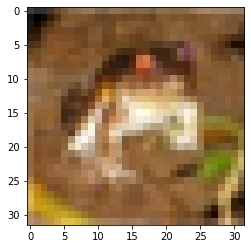

In [11]:
from sklearn.preprocessing import OneHotEncoder

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convertendo os ys para one hot encoding
y_train_oh = OneHotEncoder().fit_transform(y_train).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test).toarray()

plt.imshow(x_train[0])
plt.show()

## Treinando modelo ConvNet

O modelo criado baseado no LeNet5 utiliza a mesma quantiade de camadas porém com quantidade de kernels diferentes da versão original. Aumentando a quantidade de kernels nas camadas convolucionais nós esperamos que a acurácia do modelo aumente, gerando feature vectors mais descritivas.

In [12]:
MODEL_FILE_NAME = "convnet-model.h5"
LOAD_MODEL = os.path.isfile(MODEL_FILE_NAME)

if LOAD_MODEL:
    model = tf.keras.models.load_model(MODEL_FILE_NAME)
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(84, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    model.fit(
        x_train,
        y_train_oh,
        batch_size=256,
        epochs=25,
        verbose=2,
        validation_data=(x_test, y_test_oh))

    model.save(MODEL_FILE_NAME)

Epoch 1/25
196/196 - 11s - loss: 2.6747 - accuracy: 0.3190 - val_loss: 1.4796 - val_accuracy: 0.4577
Epoch 2/25
196/196 - 11s - loss: 1.3815 - accuracy: 0.5047 - val_loss: 1.3082 - val_accuracy: 0.5334
Epoch 3/25
196/196 - 11s - loss: 1.1847 - accuracy: 0.5809 - val_loss: 1.1851 - val_accuracy: 0.5837
Epoch 4/25
196/196 - 10s - loss: 1.0493 - accuracy: 0.6333 - val_loss: 1.1120 - val_accuracy: 0.6168
Epoch 5/25
196/196 - 10s - loss: 0.9416 - accuracy: 0.6709 - val_loss: 1.1061 - val_accuracy: 0.6197
Epoch 6/25
196/196 - 10s - loss: 0.8516 - accuracy: 0.7051 - val_loss: 1.0579 - val_accuracy: 0.6440
Epoch 7/25
196/196 - 10s - loss: 0.7794 - accuracy: 0.7281 - val_loss: 1.0612 - val_accuracy: 0.6497
Epoch 8/25
196/196 - 11s - loss: 0.6887 - accuracy: 0.7616 - val_loss: 1.0434 - val_accuracy: 0.6622
Epoch 9/25
196/196 - 10s - loss: 0.6055 - accuracy: 0.7894 - val_loss: 1.0711 - val_accuracy: 0.6524
Epoch 10/25
196/196 - 11s - loss: 0.5420 - accuracy: 0.8127 - val_loss: 1.1474 - val_accura

## Gerando estatísticas para modelo ConvNet

Aqui geramos as estatísticas de acurácia e a matriz de confusão do algoritmo do ConvNet

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Utilizando a ConvNet nos dados de treino e validação
train_y_pred = np.argmax(model.predict(x_train), axis=1)
test_y_pred = np.argmax(model.predict(x_test), axis=1)

# Printando as estatísticas
print("Conv Net Training Report")
print(" - Accuracy =", 100 * accuracy_score(y_train.flatten(), train_y_pred), "%")
print(" - Confusion matrix:")
print(confusion_matrix(y_train.flatten(), train_y_pred))
print("\n")
print("Conv Net Forest Validation Report")
print(" - Accuracy =", 100 * accuracy_score(y_test.flatten(), test_y_pred), "%")
print(" - Confusion matrix:")
print(confusion_matrix(y_test.flatten(), test_y_pred))

Conv Net Training Report
 - Accuracy = 0.9748 %
 - Confusion matrix:
[[4947    1   14    7    4    4    6    5    5    7]
 [   6 4935    5   13    5    3    9    8    4   12]
 [  33    1 4842   15   31   22   44    8    1    3]
 [   5    0   24 4849   21   55   29   12    1    4]
 [   6    0   40   25 4835   23   51   12    5    3]
 [   9    0   28   63   24 4838   21   14    0    3]
 [   3    1    8   15    9   13 4948    3    0    0]
 [   6    1   13    9   31   20    5 4913    1    1]
 [ 139   10   26   28   11    5    8    3 4766    4]
 [  15   30   18   15    4    9   14   11   17 4867]]


Conv Net Forest Validation Report
 - Accuracy = 0.6488 %
 - Confusion matrix:
[[716  26  59  24  36  18  17  17  59  28]
 [ 32 770  19  23   9   9  17  12  20  89]
 [ 55   6 549  78 101  80  78  32   9  12]
 [ 31  10  91 449  78 186  69  64   8  14]
 [ 30   5  84  66 610  48  80  62   6   9]
 [ 16   8  64 197  56 548  47  50   6   8]
 [  7   6  54  77  40  35 757  10   8   6]
 [ 22   3  50  56  

## Obtendo os feature maps (e vectors) dos dados

Aqui criamos um novo modelo (```feature_model```) que consiste no modelo original porém sem as camadas densas. Esse modelo vai ser útil visto que a saída dele será exatamente os feature maps que podem ser facilmente convertidos nos feature vectors que serão utilizados como entrada para o algoritmo de classificação.

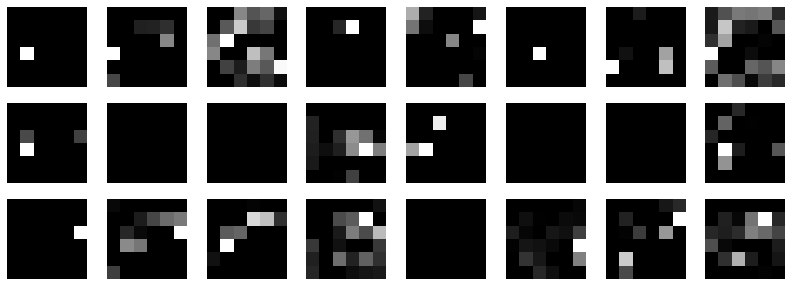

In [31]:
# Criando o modelo sem a parte das camadas Densas
feature_model = tf.keras.Model(model.inputs, model.layers[-5].output)

# Utilizando esse modelo nos dados de treino e validação para obtermos os feature vectores
train_features = feature_model.predict(x_train)
test_features = feature_model.predict(x_test)

# Plotando alguns feature maps da primeira imagem para visualização
sample_feature_map = train_features[0]
fig, axs = plt.subplots(3, 8, figsize=(14, 5))
for i in range(3):
    for j in range(8):
        axs[i, j].set_axis_off()
        axs[i, j].imshow(sample_feature_map[:, :, i * 8 + j], cmap="gray")
        
plt.show()

# Fazendo os feature maps virarem feature vectors
train_features = train_features.reshape((train_features.shape[0], -1))
test_features = test_features.reshape((test_features.shape[0], -1))

## Gerando estatísticas para modelo Random Forest

Aqui é definido o modelo de Random Forest que é treinado com os feature vectors obtidos na célula anterior. Após isso geramos os resultados de acurácia e matriz de confusão para o resultado

In [6]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=128, max_depth=16, random_state=0)
random_forest_model.fit(train_features, y_train.flatten())

train_y_pred = random_forest_model.predict(train_features)
test_y_pred = random_forest_model.predict(test_features)

print("Random Forest Training Report")
print(" - Accuracy =", accuracy_score(y_train.flatten(), train_y_pred), "%")
print(" - Confusion matrix:")
print(confusion_matrix(y_train.flatten(), train_y_pred))
print("\n")
print("Random Forest Validation Report")
print(" - Accuracy =", accuracy_score(y_test.flatten(), test_y_pred), "%")
print(" - Confusion matrix:")
print(confusion_matrix(y_test.flatten(), test_y_pred))

Random Forest Training Report
 - Accuracy = 0.9968 %
 - Confusion matrix:
[[4979    2    1    1    2    0    3    0   12    0]
 [   0 4991    0    0    0    0    1    0    8    0]
 [   1    0 4969    5    9    5    9    0    2    0]
 [   0    0    1 4981    7    1    9    0    1    0]
 [   0    0    0    3 4989    3    5    0    0    0]
 [   0    0    0    1   12 4986    1    0    0    0]
 [   0    0    0   10    7    2 4980    0    1    0]
 [   0    0    0    5    5    6    1 4983    0    0]
 [   0    0    0    3    0    0    0    0 4997    0]
 [   3    3    1    0    0    1    0    1    6 4985]]


Random Forest Validation Report
 - Accuracy = 0.6192 %
 - Confusion matrix:
[[649  54  57  22  13  11  13  14 130  37]
 [ 31 759   3  13   4   4  16   6  41 123]
 [ 72  19 399 106 121  93  93  50  26  21]
 [ 16  12  61 428  78 208 101  51  16  29]
 [ 26   9  72  81 522  47  98 110  23  12]
 [ 13   5  49 184  47 571  28  67  18  18]
 [  9  16  48  79  47  22 756  13   4   6]
 [ 10   7  30  6

## Conclusão

O método proposto é interessante e mostra o quão bom são os feature maps inferidos pelas rede convolucionais, principalmente quando comparamos os resultados obtidos pela implementação baseada em bag of words na outra parte do trabalho.

De forma análoga, nesse trabalho também foi possível ver que em certas aplicações redes neurais conseguem resultados melhores que métodos mais "tradicionais" como o Random Forest, gerando uma diferença de 5% de acurácia entre os dois métodos.